In [1]:
import cv2 as cv
import time
import win32gui, win32ui, win32con, win32api
import numpy as np
import dxcam
from ultralytics import YOLO
from IPython.display import display, clear_output
from win32api import GetSystemMetrics
import pydirectinput
import scipy
import ctypes
import math
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction
from matplotlib import pyplot as plt



In [2]:
################## 𝘽𝘼𝙎𝙄𝘾 𝘾𝙊𝙉𝙁𝙄𝙂 ##################
#PAY ATTENTION !!!: It is not recommended to change the basic config if everything is already working fine and you do not understand how this code works

FPS=True # if True - FPS and averageFPS will be displayed
VERBOSE=False #if True - detected boxes will be drawn(it will decrease FPS by a lot)


#Choose one of these two:
PREDICT=True #if True - will detect large and medium-sized targets (this is enough for most games, so it is not recommended to change this parameter)
SAHI=False #if True - will detect small and medium sized targets (this will reduce FPS by about 10x, so its an option only for rich guys with powerful GPU)

SAHI_CT=0.3 #a threshold that defines how confident the SAHI must be to detect an object


YOLO_CONFIDENCE_THRESHOLD=0.5 #a threshold that defines how confident the YOLO must be to detect an object
IOU=0.5 #Intersection Over Union (IOU)


dw = win32api.GetSystemMetrics(0) #display width in pixels
dh = win32api.GetSystemMetrics(1) #display height in pixels





################## 𝙐𝙎𝙀𝙍 𝘾𝙊𝙉𝙁𝙄𝙂 ##################
MODEL_PATH='nmodel.pt'#path to neural network model


#These 4 parameters specifies screen area where targets will be detected
#The neural network model will give a better results if this screen area is square 
LEFT=int(dw*0.4428) # On the X scale, the upper left corner of the box
TOP=int(dh*0.352) # On the Y scale, the upper left corner of the box
RIGHT=int(dw*0.6095) # On the X scale, the lower right corner of the box
BOTTOM=int(dh*0.6483) # On the Y scale, the lower right corner of the box


AIM_ASSIST=True #if True - it is automatically aimed at the target in the specified window
AUTO_TRIGGER=True #if True - it is automatically shoots when the cursor is within the detected box


#Choose one of these two:
ALWAYS_ACTIVE=False #if True - will work all the time regardless of whether the aim button is pressed or not
ACTIVATE_KEY=0x02 #Specifies a virtual key(Right mouse button by default).Aim assist and auto-trigger will work only when this key is pressed.  
#If the desired virtual key is a letter or digit (A through Z, a through z, or 0 through 9), key must be set to the ASCII value of that character. 
#For other keys, it must be a virtual-key code. Link to virtual key codes: https://learn.microsoft.com/en-us/windows/win32/inputdev/virtual-key-codes

END_KEY=0x70 #Also specify a button that will terminate this program(F1 by default)


#AIM ASSIST CONFIG(needed only if AIM_ASSIST=True)
SCALE=0.3 #determines how big the steps will be when the aim assist brings the cursor to the target.
#If this variable is too small, the movement will be slow, if it is too high, the movement will be jerky.
#You have to determine this variable yourself by trial and error.


#Where to aim? 
HEAD=True #if True - will aim at the target's head
BODY=False #if True - will aim at the target's body
RABDOM=False #if True - will aim to random point 



YOUR ZONE WHERE THE TARGETS WILL BE DETECTED IS: 
LEFT=850 pixels 
TOP=380 pixels 
RIGHT=1170 pixels 
BOTTOM=700 pixels 
The neural network model will give a better results if this screen area is square


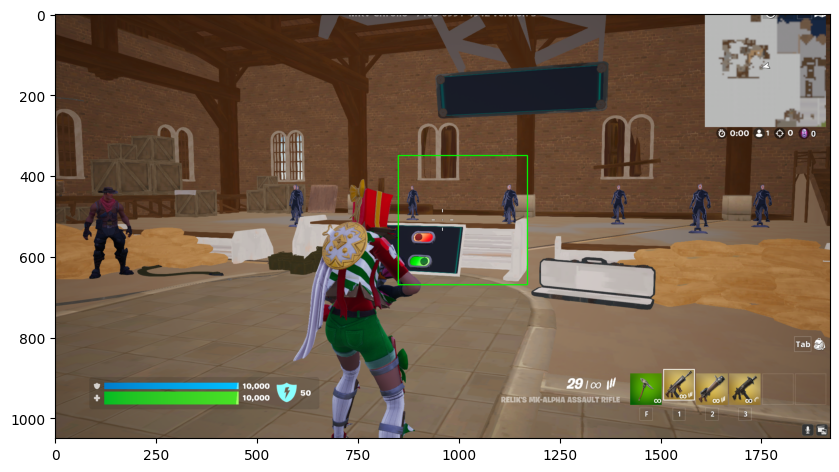

In [3]:
#This cell will create only one screenshot and show the area where target detection will be performed
camera = dxcam.create()
frame = camera.grab((0,30,dw,dh))
image_with_box=cv.rectangle(frame,[LEFT,TOP-30],[RIGHT,BOTTOM-30],[0,255,0], 2)
# cv.imshow('Area where target detection will be performed',image_with_box)
plt.figure(figsize=(10,10))
plt.imshow(image_with_box)

print("YOUR ZONE WHERE THE TARGETS WILL BE DETECTED IS: ")
print('LEFT='+str(LEFT),'TOP='+str(TOP),'RIGHT='+str(RIGHT),'BOTTOM='+str(BOTTOM), sep=' pixels \n', end=' pixels \n')
print('The neural network model will give a better results if this screen area is square')

del camera


In [4]:
dc = win32gui.GetDC(0)
dcObj = win32ui.CreateDCFromHandle(dc)
hwnd = win32gui.WindowFromPoint((0,0))
monitor = (0, 0, dw, dh)

b1 = win32ui.CreateBrush()
b1.CreateSolidBrush(win32api.GetSysColor(0))



def box_in_center(box):
    if box[0]+LEFT<dw/2 and box[2]+LEFT>dw/2 and box[1]+TOP<dh/2 and box[3]+TOP>dh/2:
        return True
    
    return False
    

def find_closest(r):
    min_distance=1000000
    closest=[]
    
    w_shift=0
    h_shift=0.31
    
    if HEAD:
        w_shift=0
        h_shift=0.31
    elif BODY:
        w_shift=0
        h_shift=0.15
    elif RABDOM:
        w_shift=np.random.uniform(low=-0.4, high=0.4)
        h_shift=np.random.uniform(low=-0.4, high=0.4)
        
    
    if PREDICT or TRACK:
        for box in r.boxes.xywh:
            dist=math.dist([dw/2,dh/2],[ box[0]+LEFT,box[1]+TOP] )
            if dist<min_distance:
                min_distance=dist
                closest=box[0]+LEFT-box[2]*w_shift, box[1]+TOP-box[3]*h_shift
                
        return closest
        
    elif SAHI:
        for res in r.to_coco_annotations():
            
            if res['score']>SAHI_CT:
                x=res['bbox'][0] + res['bbox'][2]/2
                y=res['bbox'][1] + res['bbox'][3]/2
                dist=math.dist([dw/2,dh/2],[ x+LEFT,y+TOP])
                if dist<min_distance:
                    min_distance=dist
                    closest=x+LEFT-res['bbox'][2]*w_shift, y+TOP-res['bbox'][3]*h_shift
            else: 
                continue 
                
        return closest


def draw_box(left,top,right,bottom):
    dcObj.FrameRect((LEFT, TOP, RIGHT, BOTTOM), b1)
    dcObj.FrameRect((left+LEFT,top+TOP,right+LEFT,bottom+TOP), b1)
    win32gui.InvalidateRect(hwnd, monitor, True)

def move(closest):
    x = closest[0] - dw/2
    y = closest[1] - dh/2 

    scale = SCALE
    x = int(x * scale)
    y = int(y * scale)
    win32api.mouse_event(win32con.MOUSEEVENTF_MOVE, x, y, 0, 0)

    return

def click(duratiom=0.0):
    pydirectinput.click(duration=duratiom,_pause=False)
    return


def process_yolo_result(result):
    for r in result:
        if AIM_ASSIST:
            closest=find_closest(r)
            if len(closest)>0 and  (win32api.GetKeyState(ACTIVATE_KEY)<0 or ALWAYS_ACTIVE):
                move(closest)
                        
        if AUTO_TRIGGER: 
            for box in r.boxes.xyxy:
                if len(box) and  (win32api.GetKeyState(ACTIVATE_KEY)<0 or ALWAYS_ACTIVE):
                    if box_in_center(box):
                        click()                       
        
        if VERBOSE:
            for box in r.boxes.xyxy:
                box=[int(x) for x in box]
                draw_box(*box)
                
            display('Number of persons: '+str(len(r.boxes.xyxy)) )
            display('bboxes in xyxy format: '+str(r.boxes.xyxy) )

def process_sahi_result(result):
    if AIM_ASSIST:
        closest=find_closest(result)
        if len(closest)>0 and  (win32api.GetKeyState(ACTIVATE_KEY)<0 or ALWAYS_ACTIVE):
            move(closest)
        
    if AUTO_TRIGGER:
        for res in result.to_coco_annotations():
            if len(res) and  (win32api.GetKeyState(ACTIVATE_KEY)<0 or ALWAYS_ACTIVE) and res['score']>SAHI_CT:
                box=[res['bbox'][0],res['bbox'][1],res['bbox'][0]+res['bbox'][2],res['bbox'][1]+res['bbox'][3]]
                if box_in_center(box):
                        click()

    if VERBOSE:
         for res in result.to_coco_annotations():
            box=[res['bbox'][0],res['bbox'][1],res['bbox'][0]+res['bbox'][2],res['bbox'][1]+res['bbox'][3]]
            box=[int(x) for x in box]
            draw_box(*box)

In [5]:

camera = dxcam.create(output_color="BGR")
camera.start(region=(LEFT, TOP, RIGHT, BOTTOM))

yolo_model = YOLO(MODEL_PATH) 

sahi_model = AutoDetectionModel.from_pretrained(
    model_type='yolov8',
    model_path=MODEL_PATH,
    confidence_threshold=YOLO_CONFIDENCE_THRESHOLD,
    device="cuda:0", 
    image_size=320,
    
)


frames_counter=0
all_time=0

In [ ]:
while(win32api.GetKeyState(END_KEY)>=0):
    
    clear_output(wait=True)
    start= time.time()
    
    screenshot = camera.get_latest_frame()

    if SAHI:
        result= get_sliced_prediction(
            screenshot,
            sahi_model,
            slice_height = 128,
            slice_width = 128,
            overlap_height_ratio = 0.2,
            overlap_width_ratio = 0.2,
            verbose=True
        )

        process_sahi_result(result)
        

    if PREDICT:
        result=yolo_model.predict(screenshot,imgsz=320, conf=YOLO_CONFIDENCE_THRESHOLD,verbose=False,iou=IOU)
        process_yolo_result(result)            
    

    
    if FPS: 
        display('FPS: '+str(1/(time.time()-start+0.0015)) )
        frames_counter+=1
        all_time+=1/(time.time()-start)
        display('Avg FPS: '+str(all_time/frames_counter)) 


        



'FPS: 33.69123025414488'

'Avg FPS: 40.71234120398955'

In [ ]:
if len([2]) and  (False or False):
    print('ok')